In [1]:
#import words
words = open('names.txt', 'r').read().splitlines()

In [2]:
#check
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
#numbering
chars = sorted(list(set('' .join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
#Create  X(input) and Y(expected output)
#Create their tensors
#Create weights w1 and w2
#Create logits
#Create loss function
#Create hidden layers
#Calculate loss
#Find learning rate

In [5]:
import torch

In [6]:
#Create a function that takes parameters and return X and Y tensor for them
# Creating X and Y taking first 3 words and forming their tensor
#We need X and Y in terms of tensor
block_size = 3 # how many characters do we take to predict the next one
# ..e ----> m

def build_dataset(words):
    X,Y = [], []
    
    context =[0] *block_size
    for w in words[:5]:
        
        
        for ch in w +'.':
            ix = stoi[ch]
            
            X.append(context)
            Y.append(ix)
            context = context[1:]+ [ix]
            
            
    X=torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y    

#Create developing sets: Training, develpment and tests..
# Now this is crucial because later we need learning rate and decay rate
# The difference between training and testing gives us decay rate

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9* len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [7]:
#MLP revisited
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [8]:
# same optimization as last time
import torch.nn.functional as F
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.2957
  10000/ 200000: 0.0005
  20000/ 200000: 0.0003
  30000/ 200000: 0.0002
  40000/ 200000: 0.0001
  50000/ 200000: 0.0004
  60000/ 200000: 0.0001
  70000/ 200000: 0.0001
  80000/ 200000: 0.0001
  90000/ 200000: 0.0001
 100000/ 200000: 0.0000
 110000/ 200000: 0.0001
 120000/ 200000: 0.0000
 130000/ 200000: 0.0001
 140000/ 200000: 0.0000
 150000/ 200000: 0.0000
 160000/ 200000: 0.0000
 170000/ 200000: 0.0001
 180000/ 200000: 0.0001
 190000/ 200000: 0.0000


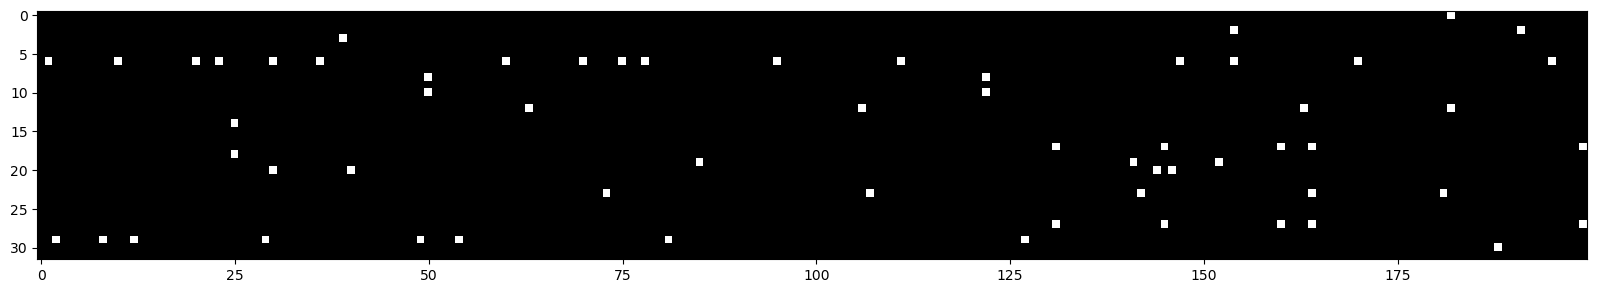

In [11]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = 'nearest')

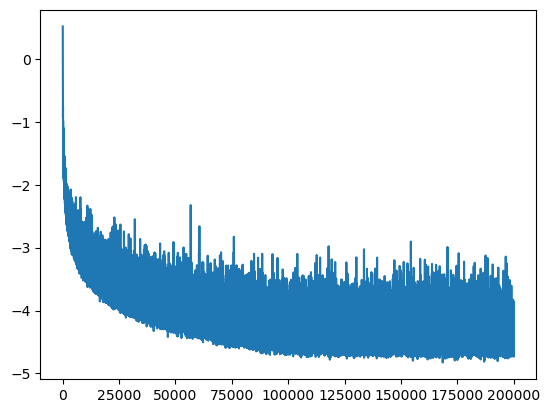

In [10]:
import matplotlib.pyplot as plt
plt.plot(lossi)

(array([1135.,  716.,  544.,  437.,  371.,  386.,  372.,  592.,  769.,
        1078.]),
 array([-9.99398708e-01, -7.99665374e-01, -5.99932039e-01, -4.00198704e-01,
        -2.00465369e-01, -7.32034445e-04,  1.99001300e-01,  3.98734635e-01,
         5.98467970e-01,  7.98201305e-01,  9.97934639e-01]),
 <BarContainer object of 10 artists>)

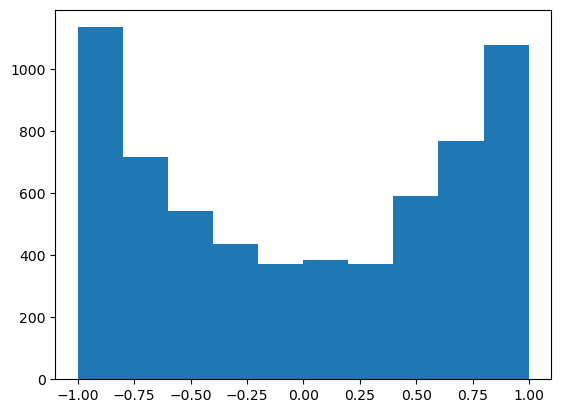

In [12]:
plt.hist(h.view(-1).tolist())

In [ ]:
logits[0]
# we need below logits to be closer to 0 but as we can see that is not the case
# to correct initial loss 27 we see what has impact on logits = h@W2 +b2
#since we want the logits to be closer to 0 we dont wanna be adding or subtracting
#instead we multiply by 0, so that b2 is 0 at initialization
#we also want W2(weight assigned to be smaller) bcoz we need logits to be closer to 0



tensor([-7.5686e-01,  6.1752e-01, -1.2532e+00, -3.0939e-01, -1.9897e-01,
        -7.6936e-01, -1.5015e-01, -2.5999e-01,  1.9400e+00,  1.1977e+00,
         1.7400e+00, -2.2042e-01, -1.2395e+00,  1.3557e+01, -8.5936e+00,
        -2.1984e+00, -2.1266e-01, -1.5721e-01, -1.5322e+00, -2.0274e-01,
        -3.4026e-03, -2.3844e-01, -2.4638e-01, -3.0333e-01, -1.9163e-01,
        -2.3720e-01, -2.1541e-01], grad_fn=<SelectBackward0>)

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.658980363572482e-05
val 10.811165809631348
